In [23]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
from time import sleep
import numpy as np
import math

In [24]:
def get_player_input(play_area, first_inputter):
    """
    プレイヤーから入力を受け付ける関数

    ゲームの状況をあらわすリストを受け取り、
    プレイヤーの入力で更新したリストと入力を返す
    """
    choosable_area = [str(area) for area in play_area if type(area) is int]
    while(True):
        player_input = input('Choose a number!>>>')
        if player_input in choosable_area:
            player_input = int(player_input)
            break
        else:
            print('Wrong input!\nChoose a number from' \
                  '{}'.format(choosable_area))
    if first_inputter == 1:
        play_area[play_area.index(player_input)] = '○'
    elif first_inputter == 2:
        play_area[play_area.index(player_input)] = '×'
    return play_area, player_input

In [25]:
def get_ai_input(play_area, first_inputter, mode=0, q_table=None, epsilon=None):
    """
    AIの入力を受け付ける関数

    ゲームの状況をあらわすリストとAIのモードおよびその他のオプションを受け取り、
    AIの入力で更新したリストと入力を返す
    """
    choosable_area = [str(area) for area in play_area if type(area) is int]
    if mode == 0:
        ai_input = int(random.choice(choosable_area))
    elif mode == 1:
        ai_input = get_ql_action(play_area, choosable_area, q_table, epsilon)
    if first_inputter == 1:
        play_area[play_area.index(ai_input)] = '×'
    elif first_inputter == 2:
        play_area[play_area.index(ai_input)] = '○'
    return play_area, ai_input

In [26]:
def show_play(play_area, inputter=0, inputted=0):
    """
    TIC TAC TOEの画面を表示する関数

    表示すべきリスト(1～9の数値、○、×から成る)と
    直前の入力者および入力を受け取り、表示する
    """
    clear_output()
    plt.figure(figsize=(6, 6))
    plt.plot()
    plt.xticks([0, 5, 10, 15])
    plt.yticks([0, 5, 10, 15])
    plt.tick_params(labelbottom='off', bottom='off')
    plt.tick_params(labelleft='off', left='off')
    plt.xlim(0, 15)
    plt.ylim(0, 15)

    x_pos = [2.5, 7.5, 12.5]
    y_pos = [2.5, 7.5, 12.5]

    markers = ['$' + str(marker) + '$' for marker in play_area]

    marker_count = 0
    for y in reversed(y_pos):
        for x in x_pos:
            if markers[marker_count] == '$○$':
                color = 'r'
            elif markers[marker_count] == '$×$':
                color = 'k'
            else:
                color = 'b'
            plt.plot(x, y, marker=markers[marker_count], 
                     markersize=30, color=color)
            marker_count += 1
    if inputter == 0:
        title = 'Play the TIC TAC TOE!!'
    else:
        title = '{} chose {}!!'.format(inputter, inputted)
    plt.title(title)
    plt.show()

In [27]:
def judge(play_area, inputter):
    """
    ゲーム終了及び勝者を判定する

    ゲームの状況をあらわすリストと直前の入力者を受け取り、
    ゲームが終了していれば勝者と終了判定を返す
    """
    end_flg = 0
    winner = 'NOBODY'
    first_list = [0, 3, 6, 0, 1, 2, 0, 2]
    second_list = [1, 4, 7, 3, 4, 5, 4, 4]
    third_list = [2, 5, 8, 6, 7, 8, 8, 6]
    for first, second, third in zip(first_list, second_list, third_list):
        if play_area[first] == play_area[second] \
        and play_area[first] == play_area[third]:
            winner = inputter
            end_flg = 1
            break
    choosable_area = [str(area) for area in play_area if type(area) is int]
    if len(choosable_area) == 0:
        end_flg = 1
    return winner, end_flg

In [28]:
def player_vs_randomAI(first_inputter):
    """
    プレイヤーとAI(ランダム)のゲームを実行する関数

    先手(1:プレイヤー、2:AI)を受け取り、ゲームが終了するまで実行する
    """
    inputter1 = 'YOU'
    inputter2 = 'AI'

    play_area = list(range(1, 10))
    show_play(play_area)
    inputter_count = first_inputter
    end_flg = 0
    while True:
        if (inputter_count % 2) == 1:
            print('Your turn!')
            play_area, player_input = get_player_input(play_area, first_inputter)
            show_play(play_area, inputter1, player_input)
            winner, end_flg = judge(play_area, inputter1)
            if end_flg:
                break
        elif (inputter_count % 2) == 0:
            print('AI\'s turn!\n.\n.\n.')
            play_area, ai_input = get_ai_input(play_area, first_inputter, mode=0)
            sleep(3)
            show_play(play_area, inputter2, ai_input)
            winner, end_flg = judge(play_area, inputter2)
            if end_flg:
                break
        inputter_count += 1
    print('{} win!!!'.format(winner))

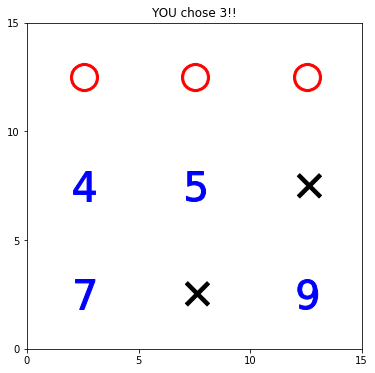

YOU win!!!


In [29]:
# ゲームしてみる
# 引数1:プレイヤー先手
# 引数2:プレイヤー後手

player_vs_randomAI(1)

In [31]:
# Qテーブル作成
def make_q_table():
    """
    Qテーブルを作成する関数
    """
    n_columns = 9
    n_rows = 3**9
    return np.zeros((n_rows, n_columns))

In [32]:
def q_learning(play_area, ai_input, reward, play_area_next, q_table, end_flg):
    """
    Qテーブルを更新する関数

    ゲームの状況をあらわすリスト・AIの行動・報酬
    １手番後のゲームの状況をあらわすリスト・Qテーブル・勝利フラグ
    を受け取り、更新したQテーブルを返す
    """
    # 行番号取得
    row_index = find_q_row(play_area)
    row_index_next = find_q_row(play_area_next)
    column_index = ai_input - 1
    # 勝利した or 敗北した場合
    if end_flg == 1:
        q_table[row_index, column_index] = \
        q_table[row_index, column_index] + eta \
        * (reward - q_table[row_index, column_index])
    # まだ続いている場合以外
    else:
        q_table[row_index, column_index] = \
        q_table[row_index, column_index] + eta \
        * (reward + gamma * np.nanmax(q_table[row_index_next,: ]) \
           - q_table[row_index, column_index])
    return q_table

In [33]:
def find_q_row(play_area):
    """
    参照時の状況(state)が参照すべき行番号を計算する関数

    ゲームの状況をあらわすリストを受け取り、行番号を返す
    """
    row_index = 0
    for index in range(len(play_area)):
        if play_area[index] == '○':
            coef = 1
        elif play_area[index] == '×':
            coef = 2
        else:
            coef = 0
        row_index += (3 ** index) * coef
    return row_index

In [34]:
def get_ql_action(play_area, choosable_area, q_table, epsilon):
    """
    AIの行動を決定する関数

    ゲームの状況をあらわすリスト・
    選択可能エリア・Qテーブル・イプシロンを受け取り、行動を返す
    """
    # esilonの確率でランダムな選択をする
    if np.random.rand() < epsilon:
        ai_input = int(random.choice(choosable_area))
    # Qテーブルに従い行動を選択する
    else:
        row_index = find_q_row(play_area)
        first_choice_flg = 1
        for choice in choosable_area:
            if first_choice_flg == 1:
                ai_input = int(choice)
                first_choice_flg = 0
            else:
                if q_table[row_index, ai_input-1] \
                < q_table[row_index, int(choice)-1]:
                    ai_input = int(choice)
    return ai_input

In [35]:
def randomAI_vs_QLAI(first_inputter, q_table, epsilon=0):
    """
    AI(ランダム)とAI(Q学習)のゲームを実行する関数

    先手(1:AI(ランダム)、2:AI(Q学習))とQテーブルを受け取り、
    ゲームが終了するまで実行する
    """
    inputter1 = 'Random AI'
    inputter2 = 'QL AI'

    # Q学習退避用
    ql_input_list = []
    play_area_list = []

    play_area = list(range(1, 10))
    #show_play(play_area)
    inputter_count = first_inputter
    end_flg = 0
    ql_flg = 0
    reward = 0
    while True:
        # Q学習退避用
        play_area_tmp = play_area.copy()
        play_area_list.append(play_area_tmp)
        # Q学習実行フラグ
        ql_flg = 0
        # AI(Q学習)の手番
        if (inputter_count % 2) == 0:
            # QL AI入力
            play_area, ql_ai_input = get_ai_input(play_area, 
                                                  first_inputter,
                                                  mode=1, 
                                                  q_table=q_table, 
                                                  epsilon=epsilon)
            winner, end_flg = judge(play_area, inputter2)
            # Q学習退避用
            ql_input_list.append(ql_ai_input)            
            # 勝利した場合
            if winner == inputter2:
                reward = 1
                ql_flg = 1
            play_area_before = play_area_list[-1]
            ql_ai_input_before = ql_input_list[-1]
        # AI(ランダム)の手番
        elif (inputter_count % 2) == 1:
            play_area, random_ai_input = get_ai_input(play_area, 
                                                      first_inputter+1, 
                                                      mode=0)
            winner, end_flg = judge(play_area, inputter1)
            # AI(ランダム)が先手の場合の初手以外は学習
            if inputter_count != 1:
                ql_flg = 1
        # Q学習実行
        if ql_flg == 1:
            ql_ai_input_before = ql_input_list[-1]
            q_table = q_learning(play_area_before, ql_ai_input_before,
                                 reward, play_area, q_table, end_flg)
        if end_flg:
            break
        inputter_count += 1
    print('{} win!!!'.format(winner))
    return winner, q_table

In [36]:
q_table = make_q_table()
eta = 0.1  # 学習率
gamma = 0.9  # 時間割引率
initial_epsilon = 0.5  # ε-greedy法の初期値

In [37]:
# ランダム vs QL(学習)
# 試行数設定
episode = 500000
winner_list = []
start = time.time()
for i in range(episode):
    epsilon = initial_epsilon * (episode-i) / episode
    winner, _ = randomAI_vs_QLAI(1, q_table, epsilon)
    winner_list.append(winner)
elapsed_time = time.time() - start
print ('elapsed_time:{0}'.format(elapsed_time) + '[sec]')

NameError: name 'time' is not defined

In [38]:
print('勝ち回数')
print('Random AI:{}'.format(winner_list.count('Random AI')))
print('QL AI    :{}'.format(winner_list.count('QL AI')))
print('NOBODY   :{}'.format(winner_list.count('NOBODY')))
print('QLの勝率 :{}'.format(winner_list.count('QL AI') / len(winner_list)))

勝ち回数
Random AI:0
QL AI    :0
NOBODY   :0


ZeroDivisionError: division by zero

In [39]:
def player_vs_QLAI(first_inputter, q_table, epsilon=0):
    """
    プレイヤーとAI(Q学習)のゲームを実行する関数

    先手(1:プレイヤー)、2:AI(Q学習))を受け取り、ゲームが終了するまで実行する
    """
    inputter1 = 'YOU'
    inputter2 = 'QL AI'

    # Q学習退避用
    ql_input_list = []
    play_area_list = []

    play_area = list(range(1, 10))
    show_play(play_area)
    inputter_count = first_inputter
    end_flg = 0
    ql_flg = 0
    reward = 0
    while True:
        # Q学習退避用
        play_area_tmp = play_area.copy()
        play_area_list.append(play_area_tmp)
        # Q学習実行フラグ
        ql_flg = 0
        # AI(Q学習)の手番
        if (inputter_count % 2) == 0:
            # QL AI入力
            play_area, ql_ai_input = get_ai_input(play_area, 
                                                  first_inputter,
                                                  mode=1, 
                                                  q_table=q_table, 
                                                  epsilon=epsilon)
            show_play(play_area, inputter2, ql_ai_input)
            winner, end_flg = judge(play_area, inputter2)
            # Q学習退避用
            ql_input_list.append(ql_ai_input)            
            # 勝利した場合
            if winner == inputter2:
                reward = 1
                ql_flg = 1
            play_area_before = play_area_list[-1]
            ql_ai_input_before = ql_input_list[-1]
        # プレイヤーの手番
        elif (inputter_count % 2) == 1:
            print('Your turn!')
            # プレイヤーの入力受付
            play_area, player_input = get_player_input(play_area, first_inputter)
            show_play(play_area, inputter1, player_input)
            winner, end_flg = judge(play_area, inputter1)
            # プレイヤーが勝利した場合
            if winner == inputter1:
                reward = -1
            # プレイヤーが先手の場合の初手以外は学習
            if inputter_count != 1:
                ql_flg = 1
        # Q学習実行
        if ql_flg == 1:
#            print('Q学習')
            ql_ai_input_before = ql_input_list[-1]
            q_table = q_learning(play_area_before, ql_ai_input_before,
                                 reward, play_area, q_table, end_flg)
        if end_flg:
            break
        inputter_count += 1
    show_play(play_area)
    print('{} win!!!'.format(winner))
    sleep(1)
    return winner, q_table

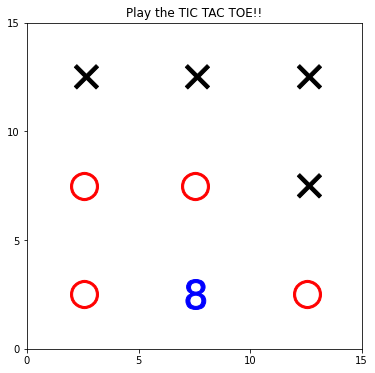

QL AI win!!!


In [58]:
# プレイヤー vs QL
# 試行数設定
episode = 1
winner_list = []
for i in range(episode):
    epsilon = initial_epsilon * (episode-i) / episode
    winner, q_table = player_vs_QLAI(1, q_table, epsilon=0)
    winner_list.append(winner)